In [1]:
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os,sys
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.switch_backend('agg')

from PIL import Image
from PIL import ImageFile
from PIL import ImageFilter
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
from numpy import linalg
import skimage.util
import scipy.ndimage.filters
import scipy.misc
import scipy.io
from scipy import stats

import utils

In [3]:
import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())

In [4]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

In [5]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [7]:
# Adding GBLUR
x_train, x_train_noisy = utils.cifar10_gblur(x_train)
x_test, x_test_noisy = utils.cifar10_gblur(x_test)

5000/50000 images done!
10000/50000 images done!
15000/50000 images done!
20000/50000 images done!
25000/50000 images done!
30000/50000 images done!
35000/50000 images done!
40000/50000 images done!
45000/50000 images done!
50000/50000 images done!
Adding GBLUR done!
5000/10000 images done!
10000/10000 images done!
Adding GBLUR done!


In [8]:
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((650000, 32, 32, 3),
 (650000, 32, 32, 3),
 (130000, 32, 32, 3),
 (130000, 32, 32, 3))

In [9]:
% matplotlib inline

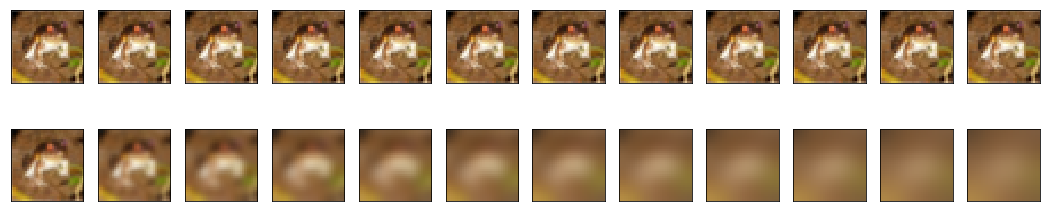

In [10]:
# Displaying noisy images
n = 13
plt.figure(figsize=(20, 4))
for i in range(1, n):
# display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
# Displaying noisy images
datadir = '/data2/rajeev/dA_IQA/data/BSDS300/images/train/'
large_files = [f for f in listdir(datadir) if isfile(join(datadir, f))]
f = datadir + large_files[i]
Iclean = mpimg.imread(f)

_, x_dist = utils.gblur_patches(Iclean)
x_dist.shape

(750, 32, 32, 3)

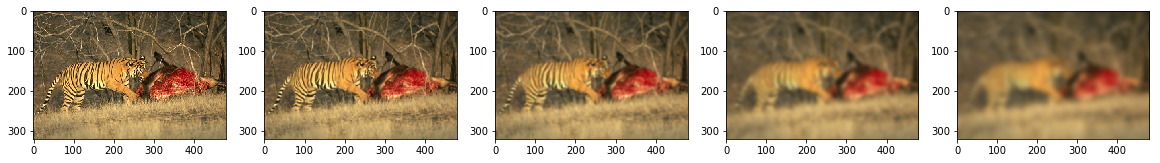

In [4]:
# Displaying noisy images
% matplotlib inline
datadir = '/data2/rajeev/dA_IQA/data/BSDS300/images/train/'
large_files = [f for f in listdir(datadir) if isfile(join(datadir, f))]
f = datadir + large_files[10]
Iclean = mpimg.imread(f)

Nr = Iclean.shape[0]/32
Nc = Iclean.shape[1]/32

_, x_dist = utils.gblur_patches(Iclean)

plt.figure(figsize=(20, 20))
for i in range(5):
    x = x_dist[150*i : 150*(i+1), :, :, :]
    vis_x = utils.visualize(x, [32, 32], [0, 0], [Nr, Nc], color=1)
    plt.subplot(1, 5, i+1), plt.imshow(vis_x)
plt.show()

In [14]:
import tensorflow as tf
import keras.backend as K

def loss_SSIM(y_true, y_pred):
    patches_true = tf.extract_image_patches(y_true, [1, 5, 5, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")
    patches_pred = tf.extract_image_patches(y_pred, [1, 5, 5, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")
    u_true = K.mean(patches_true, axis=3)
    u_pred = K.mean(patches_pred, axis=3)
    var_true = K.var(patches_true, axis=3)
    var_pred = K.var(patches_pred, axis=3)
    std_true = K.sqrt(var_true)
    std_pred = K.sqrt(var_pred)
    c1 = 0.01 ** 2
    c2 = 0.03 ** 2
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    ssim /= denom
    ssim = tf.where(tf.is_nan(ssim), K.zeros_like(ssim), ssim)
    return K.mean(-K.log(ssim))

In [15]:
import keras
from keras import losses
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, add, Lambda

L = 5
F = [16, 32, 64, 128, 256] # Number of filters at each layer

# Clean Encoder
enc_inp = Input(shape = (32, 32, 3))
encs = []
enc = enc_inp
for i in range(L):
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(2, 2))(enc)
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(1, 1))(enc)
    encs.append(enc)

encoder = Model(inputs=[enc_inp], outputs=encs)
encoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Quality
inp = Input(shape = (32, 32, 3))

enc = inp
for i in range(L):
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(2, 2))(enc)
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(1, 1))(enc)
    
    if i == L-1:
        Q = Dense(1, activation='relu')(enc)

quality = Model(inputs=[inp], outputs=[Q])
quality.compile(optimizer='adadelta', loss='mean_squared_error')

# Decoder
clean_acvns = []
for i in range(L):
    clean_acvn = Input(shape = (None, None, F[i]))
    clean_acvns.append(clean_acvn)

clean_dec = clean_acvns[L-1]
for i in range(-1, L-1)[::-1]:
    u = UpSampling2D((2, 2))(clean_dec)
    if i != -1:
        clean_dec = Conv2D(F[i], (3, 3), activation='relu', padding='same')(u)
        clean_dec = Conv2D(F[i], (3, 3), activation='relu', padding='same')(u)
        clean_dec = add([clean_dec, clean_acvns[i]])
    else:
        recon = Conv2D(3, (3, 3), activation='relu', padding='same')(u)

decoder = Model(inputs=clean_acvns, outputs=[recon])
decoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Fitting clean and distorted images
clean_input = Input(shape=(32, 32, 3))
dist_input = Input(shape=(32, 32, 3))

encs = encoder(clean_input)
q = quality(dist_input)

corr_encs = encs[0 : L-1]
corr_enc = Lambda(lambda x: x[0]*x[1])([encs[L-1], q])
corr_encs.append(corr_enc)
dist_pred = decoder(corr_encs)

IQA_model = Model(inputs=[clean_input, dist_input], outputs=[dist_pred])
IQA_model.compile(optimizer='adadelta', loss=loss_SSIM)

Tensor("ExtractImagePatches_3:0", shape=(?, 16, 16, 75), dtype=float32)


Fontconfig warning: ignoring UTF-8: not a valid region tag



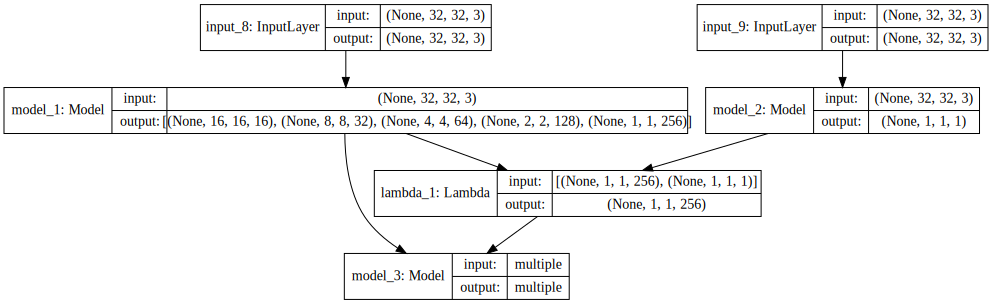

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(IQA_model, show_shapes=True).create(prog='dot', format='svg'))

In [3]:
################## Model Flow Diagram ####################
from keras.utils import plot_model
plot_model(IQA_model, to_file='my_models/cdA_gblur_model.png', show_shapes=True)

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [ ]:
from keras.callbacks import TensorBoard
import sys
IQA_model.fit([x_train, x_train_noisy],
              [x_train_noisy],
#              verbose=2,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=([x_test, x_test_noisy], 
                               [x_test_noisy]),
              callbacks=[TensorBoard(log_dir='tmp/IQA_model', histogram_freq=0, 
                                     write_graph=True, write_images=True)])

In [32]:
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
layer_dict

{'add_3': <keras.layers.merge.Add at 0x7fabf369ff10>,
 'input_43': <keras.engine.topology.InputLayer at 0x7fabf36836d0>,
 'input_44': <keras.engine.topology.InputLayer at 0x7fabf3bcaed0>,
 'model_29': <keras.engine.training.Model at 0x7fabf3c12f50>,
 'model_30': <keras.engine.training.Model at 0x7fabf3a3e510>,
 'model_31': <keras.engine.training.Model at 0x7fabf37c1e10>}

In [ ]:
from keras.models import load_model
IQA_model.save('my_models/cdA_gblur.h5')

In [16]:
from keras.models import load_model
IQA_model = load_model('my_models/cdA_gblur.h5')

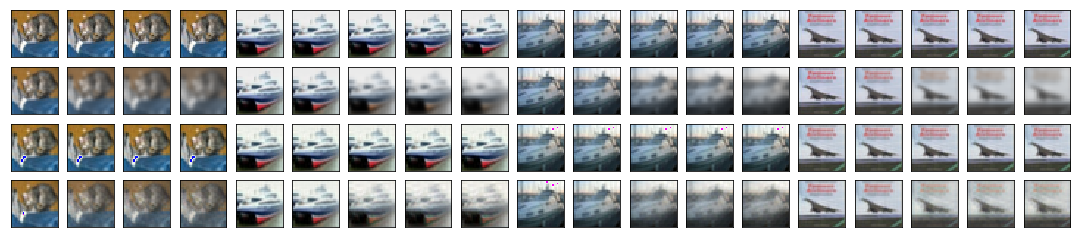

In [22]:
decoded_imgs = IQA_model.predict([x_test, x_test_noisy])

n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(4, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display distorted
    ax = plt.subplot(4, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original image reconstruction
    ax = plt.subplot(4, n, i + 2*n)
    plt.imshow(decoded_imgs[0][i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display distorted image reconstruction
    ax = plt.subplot(4, n, i + 3*n)
    plt.imshow(decoded_imgs[1][i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
decoded_imgs = IQA_model.predict([x_train[1 : 10000], x_train_noisy[1 : 100000]])

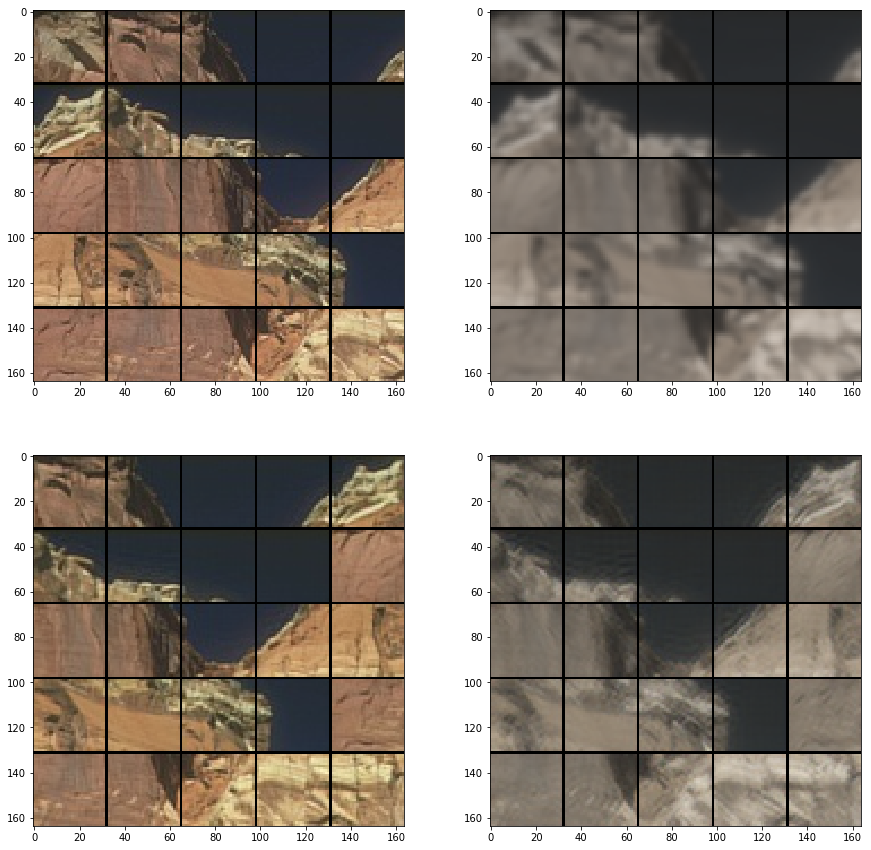

In [32]:
K = 19*150
clean_fit = decoded_imgs[0][K :]
dist_fit = decoded_imgs[1][K :]
vis_clean = utils.visualize(x_train[K :], [32, 32], [1, 1], [5, 5], color=1)
vis_dist = utils.visualize(x_train_noisy[K :], [32, 32], [1, 1], [5, 5], color=1)
vis_clean_filt = utils.visualize(clean_fit, [32, 32], [1, 1], [5, 5], color=1)
vis_dist_filt = utils.visualize(dist_fit, [32, 32], [1, 1], [5, 5], color=1)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1), plt.imshow(vis_clean)
plt.subplot(2, 2, 2), plt.imshow(vis_dist)
plt.subplot(2, 2, 3), plt.imshow(vis_clean_filt)
plt.subplot(2, 2, 4), plt.imshow(vis_dist_filt)
plt.show()

(<matplotlib.image.AxesImage at 0x7fb87c0a9550>, None)

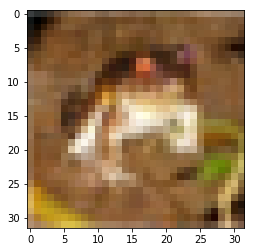

In [28]:
im = x_train[0]
im = Image.fromarray(np.uint8(im*255.))
I = np.array(im.filter(ImageFilter.GaussianBlur(radius=0)))
plt.imshow(I), plt.show()

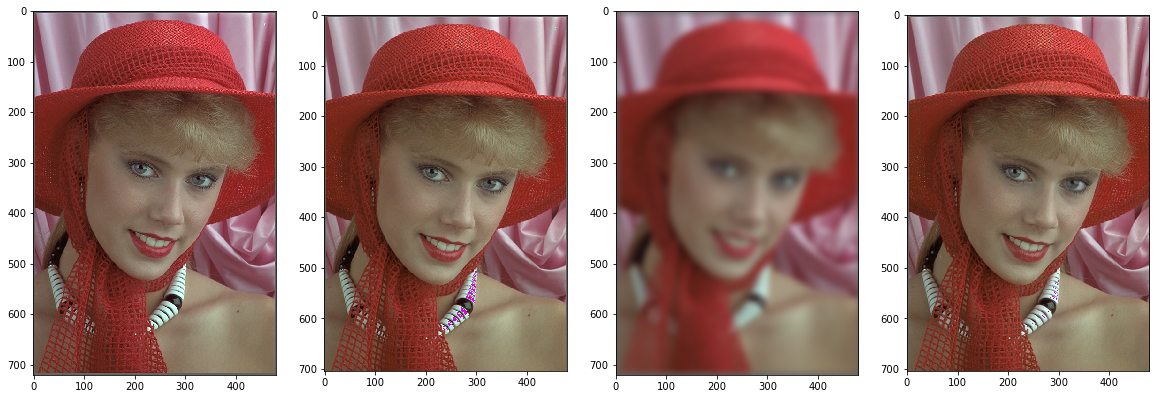

In [24]:
################################ Reconstruction ##############################
# img 162, 42, 36, 132
datadir = '/data2/rajeev/dA_IQA/data/LIVE/gblur/'
% matplotlib inline
# Clean Image
f = datadir + 'img' + str(162) + '.bmp'
Iclean = mpimg.imread(f)
Pclean = utils.getPatchesDict(Iclean, psize=[32, 32], noPatches=4000, entropy_th=1.0, stride=[32, 32])
# Distorted Image
#f = datadir + 'img' + str(132) + '.bmp'
im = Image.fromarray(np.uint8(Iclean))
Idist = np.array(im.filter(ImageFilter.GaussianBlur(radius=6)))
Pdist = utils.getPatchesDict(Idist, psize=[32, 32], noPatches=4000, entropy_th=1.0, stride=[32, 32])

Nr = Iclean.shape[0]/32
Nc = Iclean.shape[1]/32

layer = IQA_model.predict([Pclean, Pdist])

vis_clean = utils.visualize(layer[0], [32, 32], [0, 0], [Nr, Nc], color=1)
vis_dist  = utils.visualize(layer[1], [32, 32], [0, 0], [Nr, Nc], color=1)

plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1), plt.imshow(Iclean)
plt.subplot(1, 4, 2), plt.imshow(vis_clean)
plt.subplot(1, 4, 3), plt.imshow(Idist)
plt.subplot(1, 4, 4), plt.imshow(vis_dist)
plt.show()

In [15]:
from keras import backend as K
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
model2 = layer_dict['model_2']
model2_layers = dict([layer.name, layer] for layer in model2.layers)
get_distortion = K.function([model2_layers['input_2'].input],
                            [model2_layers['conv2d_10'].output])

In [78]:
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
layer_dict['conv2d_19'].output.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)])

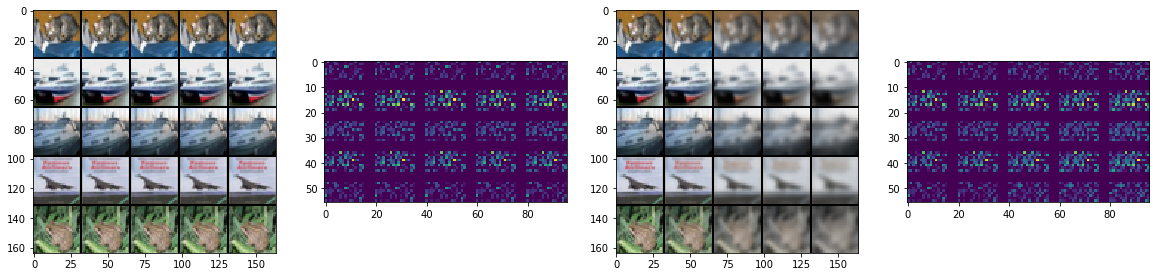

In [26]:
clean_hidden = get_distortion([x_test[0 : 100]])[0]
dist_hidden  = get_distortion([x_test_noisy[0 : 100]])[0]